In [1]:
from utils import *
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Segoe UI Symbol','simHei','Arial','sans-serif']

## Load Data

In [2]:
years = [2016,2017]
resampling_period = '10T'  # 60 minutes

original_data = load_resample_data(years, resampling_period)

# Load Windfarms.xlsx
windfarms = pd.read_excel('NRGstreamData/WindFarms.xlsx').sort_values(by='Asset ID').reset_index(drop = True)
windfarms_names = original_data.columns.tolist()    

year:2016	(105408, 20)
year:2017	(105120, 20)
resampled to  (105264, 20)


### Normalize data = Capacity Factor (optional) 

In [3]:
normalized_data = original_data / windfarms['Capacity'].values

normalized_data.head(3)

,AKE1,ARD1,BSR1,BTR1,BUL1,BUL2,CR1,CRE3,CRR1,GWW1,HAL1,IEW1,IEW2,KHW1,NEP1,OWF1,SCR2,SCR3,SCR4,TAB1
DT,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.90,0.88,0.14,0.79,0.71,0.88,0.95,0.68,0.76,0.94,0.98,0.54,0.36,0.90,0.64,0.95,0.87,0.87,0.90,0.46
2016-01-01 00:10:00,0.88,0.82,0.14,0.74,0.71,0.88,0.95,0.67,0.71,0.92,0.98,0.54,0.39,0.92,0.64,0.95,0.87,0.87,0.91,0.46
2016-01-01 00:20:00,0.86,0.83,0.15,0.72,0.71,0.81,0.95,0.67,0.71,0.90,0.98,0.47,0.35,0.89,0.66,0.91,0.90,0.89,0.91,0.51


### Clustering (optional)

In [4]:
# from sklearn.cluster import KMeans
n_clusters = 5
# kmin = KMeans(n_clusters)
# X = np.transpose(normalized_data.iloc[:,:])
# Y = kmin.fit(X)
# clusters = kmin.labels_
# clusters

clusters = np.array([1, 1, 2, 1, 4, 4, 0, 0, 0, 1, 3, 0, 0, 0, 3, 0, 1, 2, 3, 2])

a = {}
for c in range(n_clusters):
    ind = clusters == c # OR: ind = np.where(clusters==c)[0] --> this generate an np.array of only indices
    # a[c] = (normalized_data.iloc[:,ind]).mean(axis=1) : old version
    a[c] = (original_data.iloc[:,ind]).sum(axis=1) / (windfarms['Capacity'].iloc[ind].sum())
    

clustered_data = pd.DataFrame.from_dict(a)
clustered_data.columns = ['Cluster {:d}'.format(d) for d in range(1,n_clusters+1)] 

### Decide what data to use for further analysis (Original data | Normalized data | clustered_data)

In [5]:
sum_capacities_each_row = np.array(~original_data.isnull().values * windfarms['Capacity'].values).sum(axis=1)
normalized_data['Total'] = original_data.sum(axis=1)/ sum_capacities_each_row

clustered_data['Total'] = normalized_data['Total']

original_data['Total'] = original_data.sum(axis=1)

In [6]:
# #### Be catious !
data = original_data  # Normalized_data  | Original_data
data.head(3)

,AKE1,ARD1,BSR1,BTR1,BUL1,BUL2,CR1,CRE3,CRR1,GWW1,...,IEW1,IEW2,KHW1,NEP1,OWF1,SCR2,SCR3,SCR4,TAB1,Total
DT,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,66.00,59.50,43.50,52.00,10.00,14.00,37.00,20.50,58.50,67.00,...,36.00,23.50,56.50,52.50,43.50,27.00,27.00,79.50,38.00,958.00
2016-01-01 00:10:00,64.00,55.50,43.00,49.00,10.00,14.00,37.00,20.00,55.00,65.00,...,36.50,25.50,58.00,52.50,43.50,27.00,27.00,80.50,38.00,947.50
2016-01-01 00:20:00,63.00,56.50,46.00,47.50,10.00,13.00,37.00,20.00,54.50,64.00,...,31.50,23.00,56.00,54.00,42.00,28.00,27.50,80.00,42.00,942.00


In [7]:
CF_total = data['Total'].values #* 100

In [8]:
def comp_prob_matrix_rapid_change(array, time_windows = [2,3], delta_CFs = [5, 10], kind = 'ramp up'):
    prob_mat = np.zeros((len(time_windows),len(delta_CFs)))
    
    for i,time_window in enumerate(time_windows):
        print(i, end=" ")
        
        # a = np.diff(array, time_window)
        a = array[time_window:] - array[:-time_window]
        
        for j,delta_CF in enumerate(delta_CFs):
            if kind == 'RampUp':
                n_happened = sum(a > delta_CF) 
            elif kind == 'RampDown':
                n_happened = sum(a < -delta_CF) 
                
            p = n_happened / len(a)
            
            prob_mat[i,j] = p
        
    return prob_mat

In [9]:
c = int(60 / int(resampling_period[:-1]))
n_hours = 12
kind = 'RampDown'
t_windows = np.arange(c, n_hours *  c + 1)
delta_CFs = np.arange(5,101,10)
delta_CFs = np.arange(100,801,10)

prob_matrix_ramp_down = comp_prob_matrix_rapid_change(CF_total,time_windows=t_windows, delta_CFs=delta_CFs,kind=kind)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 

In [11]:
# delta_Capacity = (delta_CFs * 1500 / 100).astype('int')
delta_Capacity = delta_CFs
time_windows = t_windows / c
prob_matrix_ramp_down.shape

(67, 71)

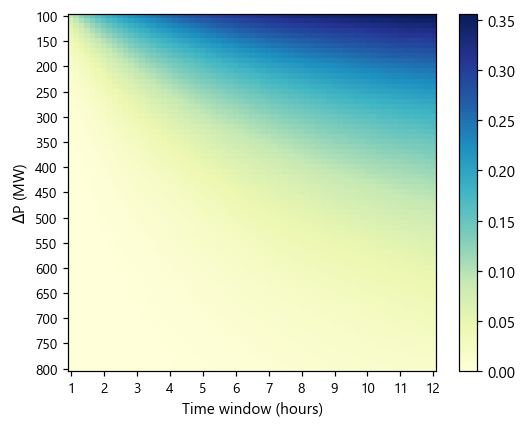

In [13]:
data_here = prob_matrix_ramp_down
d1 = data_here.shape[0]
d2 = data_here.shape[1]
x_leg = 1 * c
y_leg = 5

fig, ax = plt.subplots(figsize=(5,4),dpi=110)
cax = ax.imshow(data_here.transpose(), aspect='auto', cmap='YlGnBu') #norm=matplotlib.colors.LogNorm()

ax.set_xticks(np.arange(0, d1,x_leg))
ax.set_xticklabels(time_windows[0::x_leg].astype('int'), fontsize=9)

y_ticks_positions = np.arange(0, d2, y_leg)
# y_ticks_positions[-1] = y_ticks_positions[-1] + 1
ax.set_yticks(y_ticks_positions) #[-0.5,  4.5,  9.5, 14.5, 19.5, 24.5, 30.5]
ax.set_yticklabels(delta_Capacity[0::y_leg],fontsize=9)  # delta_Capacity or delta_CFs

# ax.spines['left'].set_position(('data', 0.0))

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax)
# cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar

ax.set_xlabel('Time window (hours)',fontsize=10)
ax.set_ylabel('$\Delta$P (MW)',fontsize=10)

fig.tight_layout()
fig.savefig('{}_in_{}hours_upto{}p.jpg'.format(kind,n_hours,max(delta_Capacity)), dpi = 300, bbox_inches='tight')    

In [14]:
c = int(60 / int(resampling_period[:-1]))
n_hours = 12
kind = 'RampUp'
t_windows = np.arange(c, n_hours *  c + 1)
delta_CFs = np.arange(5,101,10)
delta_CFs = np.arange(100,801,10)

prob_matrix_ramp_up = comp_prob_matrix_rapid_change(CF_total,time_windows=t_windows, delta_CFs=delta_CFs,kind=kind)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 

In [15]:
# delta_Capacity = (delta_CFs * 1500 / 100).astype('int')
delta_Capacity = delta_CFs
time_windows = t_windows / c
prob_matrix_ramp_up.shape

(67, 71)

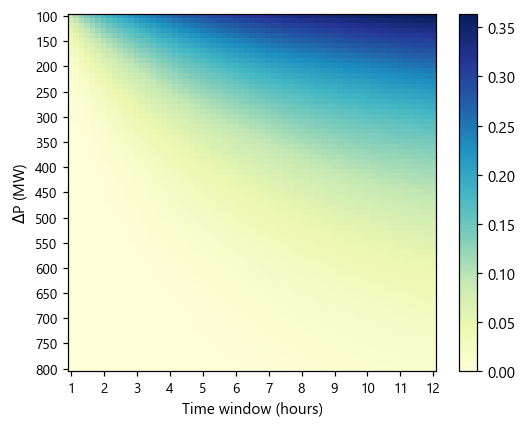

In [16]:
data_here = prob_matrix_ramp_up
d1 = data_here.shape[0]
d2 = data_here.shape[1]
x_leg = 1 * c
y_leg = 5

fig, ax = plt.subplots(figsize=(5,4),dpi=110)
cax = ax.imshow(data_here.transpose(), aspect='auto', cmap='YlGnBu') #norm=matplotlib.colors.LogNorm()

ax.set_xticks(np.arange(0, d1,x_leg))
ax.set_xticklabels(time_windows[0::x_leg].astype('int'), fontsize=9)

y_ticks_positions = np.arange(0, d2, y_leg)
# y_ticks_positions[-1] = y_ticks_positions[-1] + 1
ax.set_yticks(y_ticks_positions) #[-0.5,  4.5,  9.5, 14.5, 19.5, 24.5, 30.5]
ax.set_yticklabels(delta_Capacity[0::y_leg],fontsize=9)  # delta_Capacity or delta_CFs

# ax.spines['left'].set_position(('data', 0.0))

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax)
# cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar

ax.set_xlabel('Time window (hours)',fontsize=10)
ax.set_ylabel('$\Delta$P (MW)',fontsize=10)

fig.tight_layout()
fig.savefig('{}_in_{}hours_upto{}p.jpg'.format(kind,n_hours,max(delta_Capacity)), dpi = 300, bbox_inches='tight')    